#   Pregunta 1

### Importación de las librerias a utilizar 

In [27]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import save_img
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

### Función para transformar las imagenes de color a escala de grises 

In [28]:
# Funcion para convertir a escala de grises
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


### Función para extraer imagenes del dataset

In [32]:
# Funcion para extraer imagenes
def extraer_imagenes(directorio):
    """
    En esta parte solamente se importaran las imagenes, en la parte de mas abajo se normalizaran,
    con el fin de normalizar los datos ya estando en blanco y negro
    """
    imagenes_train=[]
    imagenes_test=[]

    for tipo_datos in ['train', 'test']:
        ruta_tipo = os.path.join(directorio, tipo_datos)
        for foto in os.listdir(ruta_tipo):
            ruta_foto=os.path.join(ruta_tipo,foto)
            try:
                img = image.load_img(ruta_foto,color_mode="rgb",target_size=(128,128))
                img_array = np.array(img)
                if tipo_datos == 'train':
                        imagenes_train.append(img_array)
                else:
                    imagenes_test.append(img_array)
            except Exception as e:
                print(f"Error al cargar {ruta_foto}: {e}")
    # Convertir a arrays y normalizar
    X_train = np.array(imagenes_train, dtype=np.float32)
    X_test = np.array(imagenes_test, dtype=np.float32)
    return X_train, X_test

### Extracción de datos de entrenamiento y testeo

In [ ]:
# Extraer imagenes
x_train, x_test = extraer_imagenes("dataset_flores")

# Definir dimensiones
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# Definir directorio
imgs_dir = 'evidencia'

# Crear directorio
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# Convertir a blanco y negro datos de entrenamiento y testeo
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

print(x_train.shape)
print(x_test.shape)

(1337, 128, 128, 3)
(336, 128, 128, 3)


### Normalización de datos y definición de dimensiones del autoencoder

In [ ]:
# Normalizar
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Normalizar datos en escala de grises
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# Reshape
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# Reshape datos en escala de grises
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

# Definir dimensiones del autoencoder
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 512
layer_filters = [64, 128, 256]
# Aumentador de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Generar datos aumentados
train_generator = datagen.flow(x_train, x_train, batch_size=32)
train_generator_gray = datagen.flow(x_train_gray, x_train_gray, batch_size=32)

print(x_train.shape)
print(x_test.shape)

In [ ]:
# Guardar imagenes
def guardarImagenes(X_train_gray, X_test_gray):
    os.makedirs("imagenes_guardadas/train", exist_ok=True)
    os.makedirs("imagenes_guardadas/test", exist_ok=True)
    for i, img in enumerate(X_train_gray):
        # Asegura que tenga forma (alto, ancho, 1)
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        ruta = f"imagenes_guardadas/train/img_{i}.jpg"
        save_img(ruta, img, scale=True)
    for i, img in enumerate(X_test_gray):
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        ruta = f"imagenes_guardadas/test/img_{i}.jpg"
        save_img(ruta, img, scale=True)
        
guardarImagenes(x_train_gray,x_test_gray)

In [8]:
# Encoder

# Definir arquitectura
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)
    
# Definir salida
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 512)               33554944  
                                                                 
Total params: 33,924,608
Trainable params: 33,924,608
Non-t

In [9]:
# Decoder

# Definir arquitectura
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)

# Definir salida
outputs = Conv2DTranspose(filters=channels,kernel_size=kernel_size,
                          activation='sigmoid',padding='same',name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 65536)             33619968  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

In [10]:
# Autoencoder

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 encoder (Functional)        (None, 512)               33924608  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       34580611  
                                                                 
Total params: 68,505,219
Trainable params: 68,505,219
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamiento

# Guardar modelos
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
accuracies = history.history['val_loss']
mejor_epoca = np.argmin(accuracies) + 1
# Definir callbacks
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=2,verbose=1,min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1,save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss',patience=10,verbose=1,restore_best_weights=True)

callbacks = [lr_reducer, checkpoint, earlyStopping]

# Compilar
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Entrenar
history = autoencoder.fit(x_train_gray,x_train,
                        validation_data=(x_test_gray, x_test),
                        epochs = 100,
                        batch_size=batch_size,
                        callbacks=callbacks)

42/42 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.5009
Epoch 1: accuracy improved from -inf to 0.50088, saving model to c:\Users\jluen\OneDrive\Documentos\Universidad\1° Semestre 2025\IMA 543\Evaluación 2\Tarea_Grupal_2\Tarea_Grupal_2\saved_models\colorized_ae_model.001.h5
42/42 [==============================] - 55s 1s/step - loss: 0.0622 - accuracy: 0.5009 - val_loss: 0.0543 - val_accuracy: 0.5047 - lr: 0.0010


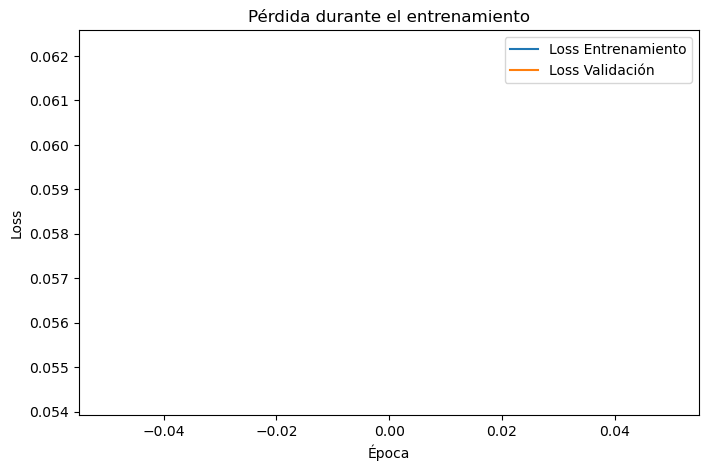

In [ ]:
# Graficar pérdida (loss)
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Loss Entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Loss Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.savefig('evidencia/grafico_perdida.png')
plt.show()

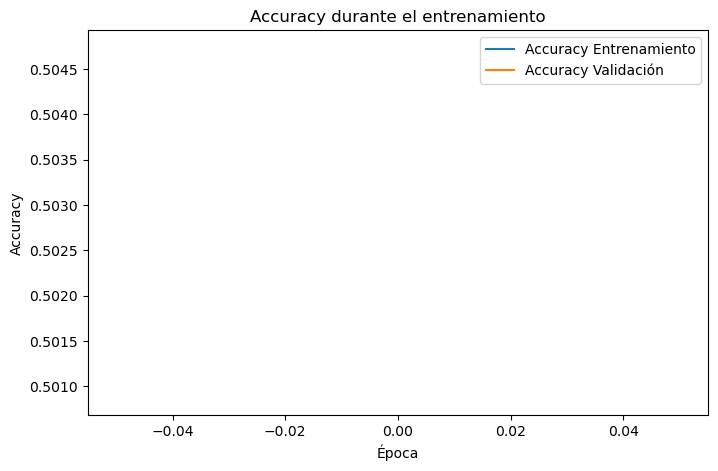

In [ ]:
# Si tienes métricas tipo accuracy, también puedes graficarlas así:
if 'accuracy' in history.history:
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Accuracy Entrenamiento')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Accuracy Validación')
    plt.title('Accuracy durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('evidencia/grafico_rendimiento.png')
    plt.show()


In [9]:
from tensorflow.keras.models import load_model

autoencoder_model = load_model('saved_models\colorized_ae_model.100.h5')

In [10]:
x_decoded = autoencoder_model.predict(x_test_gray)

x_decoded_gray = rgb2gray(x_decoded)

# Calcular MSE por imagen
def calculo_mse(testing, prediction):
    mses = []
    for i in range(len(x_test)):
        mse_i = mean_squared_error(
            testing[i].reshape(-1),
            prediction[i].reshape(-1)
        )
        mses.append(mse_i)
    mses = np.array(mses)
    return mses

mses = calculo_mse(x_test, x_decoded)
mses_gray = calculo_mse(x_test_gray, x_decoded_gray)

11/11 [==============================] - 3s 222ms/step


In [11]:
# Índices de 3 mejores (menor MSE) y 3 peores (mayor MSE)
mejores_idx = mses.argsort()[:3]
peores_idx = mses.argsort()[-3:]


print("Índices de 3 imágenes con mejor MSE:", mejores_idx)
print("Índices de 3 imágenes con peor MSE:", peores_idx)

Índices de 3 imágenes con mejor MSE: [181 112 101]
Índices de 3 imágenes con peor MSE: [254  52 326]


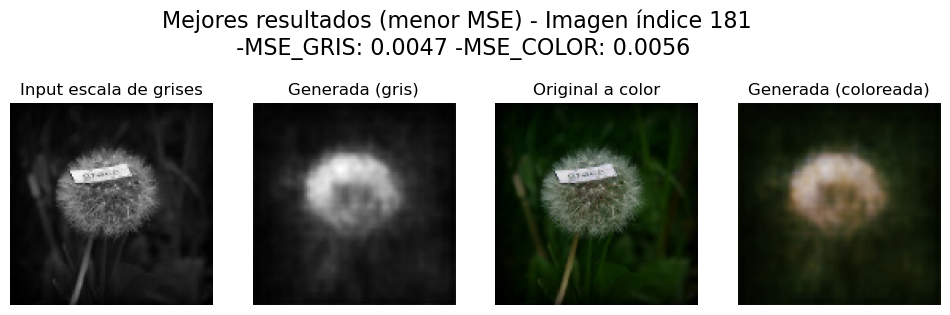

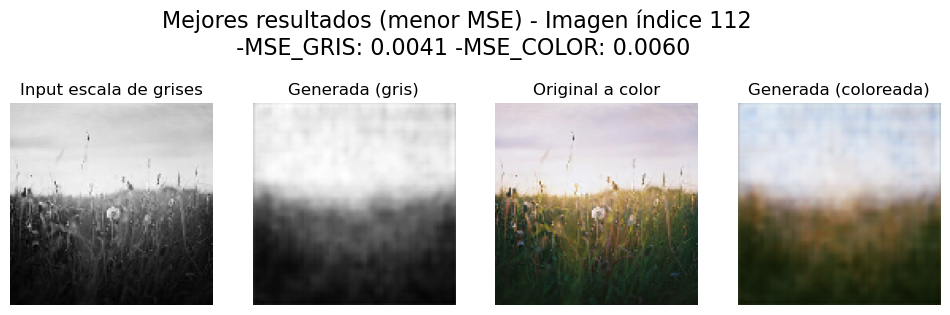

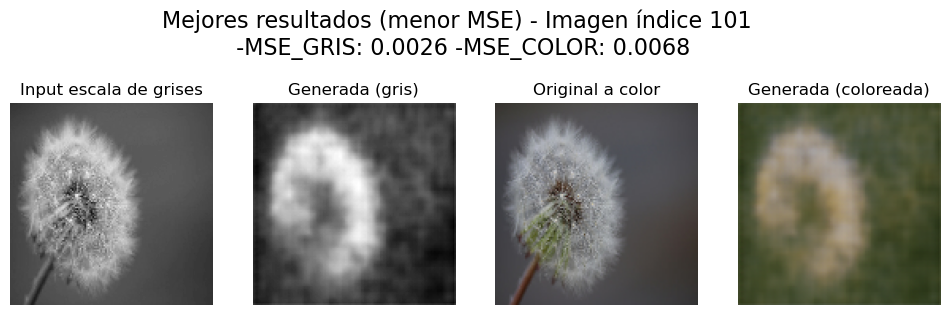

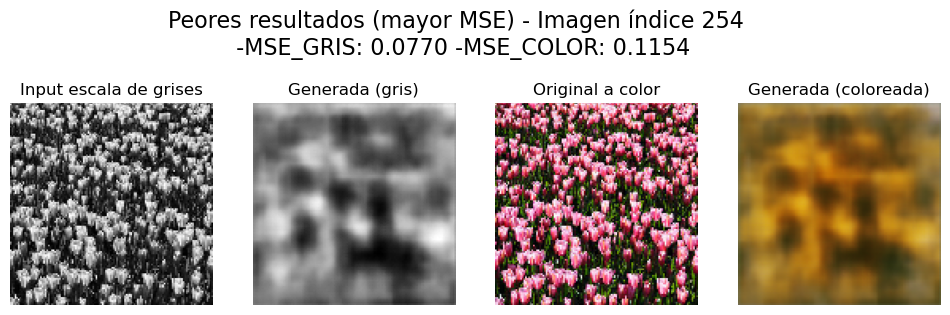

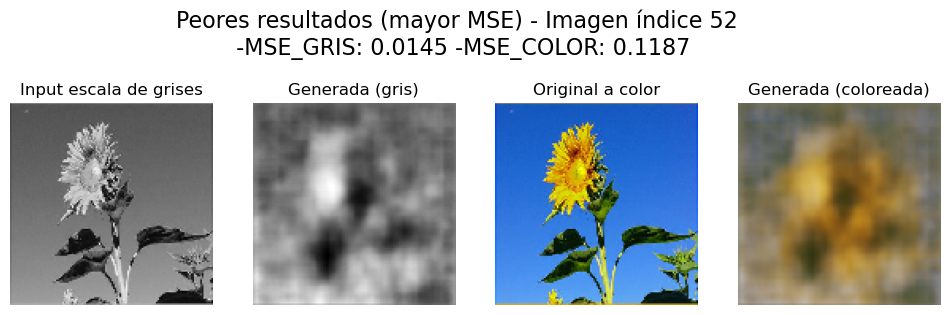

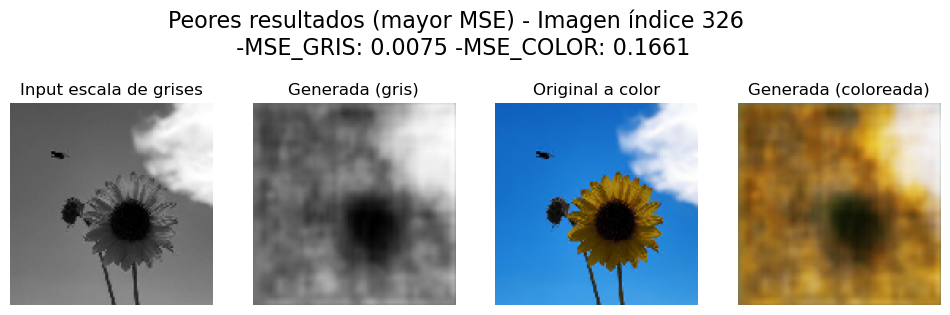

In [19]:
def mostrar_cuarteto(idx_list, titulo, mses_array, mses_array_gray):
    for idx in idx_list:
        plt.figure(figsize=(12,4))
        plt.suptitle(f'{titulo} - Imagen índice {idx} \n -MSE_GRIS: {mses_array_gray[idx]:.4f} -MSE_COLOR: {mses_array[idx]:.4f}', fontsize=16)


        # Gris original
        plt.subplot(1,4,1)
        plt.title("Input escala de grises")
        img_gray = (x_test_gray[idx].squeeze() * 255).astype(np.uint8)
        plt.imshow(img_gray, cmap='gray')
        plt.axis('off')

        # Generada
        plt.subplot(1,4,2)
        plt.title("Generada (gris)")
        img_pred = (np.clip(x_decoded_gray[idx].squeeze(), 0, 1) * 255).astype(np.uint8)
        plt.imshow(img_pred, cmap='gray')
        plt.axis('off')

        # Original a color
        plt.subplot(1,4,3)
        plt.title("Original a color")
        img_color = (x_test[idx].squeeze() * 255).astype(np.uint8)
        plt.imshow(img_color)
        plt.axis('off')

        # Generada
        plt.subplot(1,4,4)
        plt.title("Generada (coloreada)")
        img_pred = (np.clip(x_decoded[idx].squeeze(), 0, 1) * 255).astype(np.uint8)
        plt.imshow(img_pred)
        plt.axis('off')

        plt.savefig(f"evidencia/grafico_ {titulo}_{idx}.png")
        plt.show()
# Mostrar mejores y peores
mostrar_cuarteto(mejores_idx, "Mejores resultados (menor MSE)", mses, mses_gray)
mostrar_cuarteto(peores_idx, "Peores resultados (mayor MSE)", mses, mses_gray)

In [ ]:

# Función pérdida MSE simple (ya existe en keras: 'mse')
loss_mse = 'mse'

# Función pérdida MAE simple (ya existe en keras: 'mae')
loss_mae = 'mae'

In [ ]:
def entrenar_y_guardar(loss_function, nombre_modelo, x_train_gray, x_train):
    print(f"Entrenando con función de pérdida: {loss_function}")
    model = autoencoder  # Crear modelo nuevo para cada entrenamiento
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    history = model.fit(x_train_gray,x_train,
                        validation_data=(x_test_gray, x_test),
                        epochs = 100,
                        batch_size=batch_size,
                        callbacks=callbacks)

    model.save(f'autoencoder_{nombre_modelo}.h5')

    return model, history

# Entrenar con MSE
model_mse, history_mse = entrenar_y_guardar('mse', 'mse', x_train_gray, x_train)

# Entrenar con MAE
model_mae, history_mae = entrenar_y_guardar('mae', 'mae', x_train_gray, x_train)

# Graficar pérdidas comparativas
plt.figure(figsize=(10,6))
plt.plot(history_mse.history['loss'], label='Train Loss MSE')
plt.plot(history_mse.history['val_loss'], label='Val Loss MSE')
plt.plot(history_mae.history['loss'], label='Train Loss MAE')
plt.plot(history_mae.history['val_loss'], label='Val Loss MAE')
plt.title('Comparación de pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.savefig("evidencia/grafico_comparativo.png")
plt.show()

# Evaluar MSE promedio sobre test para cada modelo
def mse_promedio_test(modelo, x_test_gray, x_test_color):
    x_pred = modelo.predict(x_test_gray)
    mses = [mean_squared_error(x_test_color[i].reshape(-1), x_pred[i].reshape(-1))
            for i in range(len(x_test_color))]
    return np.mean(mses), mses, x_pred

mean_mse_mse, mses_mse, x_pred_mse = mse_promedio_test(model_mse, x_test_gray, x_test)
mean_mse_mae, mses_mae, x_pred_mae = mse_promedio_test(model_mae, x_test_gray, x_test)

print(f"MSE promedio en test con pérdida MSE: {mean_mse_mse:.4f}")
print(f"MSE promedio en test con pérdida MAE: {mean_mse_mae:.4f}")

# Mostrar algunas imágenes para comparar los resultados
def mostrar_comparacion(idx_list):
    for idx in idx_list:
        plt.figure(figsize=(16,4))
        plt.suptitle(f'Comparación resultados - Imagen {idx}', fontsize=16)

        # Input gris
        plt.subplot(1,4,1)
        plt.title("Input gris")
        plt.imshow((x_test_gray[idx].squeeze() * 255).astype(np.uint8), cmap='gray')
        plt.axis('off')

        # Original color
        plt.subplot(1,4,2)
        plt.title("Original color")
        plt.imshow((x_test[idx].squeeze() * 255).astype(np.uint8))
        plt.axis('off')

        # Generada MSE
        plt.subplot(1,4,3)
        plt.title("Generada (pérdida MSE)")
        img_pred = (np.clip(x_pred_mse[idx].squeeze(),0,1)*255).astype(np.uint8)
        plt.imshow(img_pred)
        plt.axis('off')

        # Generada MAE
        plt.subplot(1,4,4)
        plt.title("Generada (pérdida MAE)")
        img_pred = (np.clip(x_pred_mae[idx].squeeze(),0,1)*255).astype(np.uint8)
        plt.imshow(img_pred)
        plt.axis('off')
        plt.savefig(f"evidencia/grafico_comparación_resultados_{idx}.png")
        plt.show()

# Mostrar imágenes para comparar
indices_para_mostrar = mejores_idx
mostrar_comparacion(indices_para_mostrar)

4/4 [==============================] - 1s 174ms/step


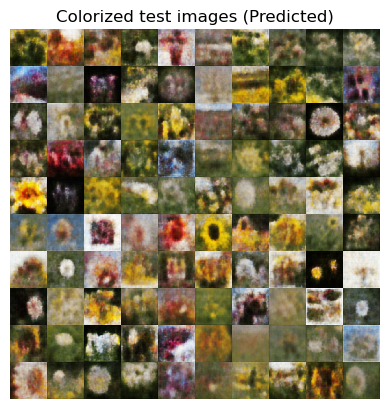

In [16]:
x_decoded = autoencoder_model.predict(x_test_gray[2:102])

imgs = x_decoded
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('colorized_prueba.png')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()